In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.max_rows = 500

In [42]:
data0 = pd.read_csv('Data/3/prices_round_3_day_0.csv', sep = ';', header = 0)
data1 = pd.read_csv('Data/3/prices_round_3_day_1.csv', sep = ';', header = 0)
data2 = pd.read_csv('Data/3/prices_round_3_day_2.csv', sep = ';', header = 0)

data2

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,2,0,PICNIC_BASKET2,30094.0,11.0,30093.0,27.0,NaN,NaN,30099,1,30100.0,37.0,NaN,NaN,30096.5,0.0
1,2,0,VOLCANIC_ROCK_VOUCHER_9750,469.0,11.0,NaN,NaN,NaN,NaN,470,11,NaN,NaN,NaN,NaN,469.5,0.0
2,2,0,RAINFOREST_RESIN,9992.0,35.0,NaN,NaN,NaN,NaN,10008,35,NaN,NaN,NaN,NaN,10000.0,0.0
3,2,0,VOLCANIC_ROCK_VOUCHER_9500,718.0,11.0,NaN,NaN,NaN,NaN,719,11,NaN,NaN,NaN,NaN,718.5,0.0
4,2,0,VOLCANIC_ROCK,10218.0,150.0,10217.0,64.0,NaN,NaN,10219,150,10220.0,64.0,NaN,NaN,10218.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139995,2,999900,PICNIC_BASKET2,30073.0,1.0,30072.0,39.0,NaN,NaN,30078,20,30079.0,20.0,NaN,NaN,30075.5,0.0
139996,2,999900,VOLCANIC_ROCK_VOUCHER_9750,417.0,20.0,NaN,NaN,NaN,NaN,418,20,NaN,NaN,NaN,NaN,417.5,0.0
139997,2,999900,PICNIC_BASKET1,58422.0,1.0,58421.0,39.0,NaN,NaN,58432,20,58433.0,20.0,NaN,NaN,58427.0,0.0
139998,2,999900,CROISSANTS,4241.0,143.0,NaN,NaN,NaN,NaN,4242,143,NaN,NaN,NaN,NaN,4241.5,0.0


Starting IV time series plotting (with pre-downsampling and IV filtering).
df_merged exists with 150000 rows.
Pre-downsampling df_merged by factor of 1...
Row count after pre-downsampling: 150000
Computing v_t (implied volatility) for pre-downsampled data...


100%|█████████████████████████████████████████████████████████████████████████| 150000/150000 [13:04<00:00, 191.29it/s]


v_t computed in 784.16 seconds. Current row count: 150000
Filtered out unsensible v_t values. Rows before: 150000, after: 135152.
Composite time computed. Final row count: 135152


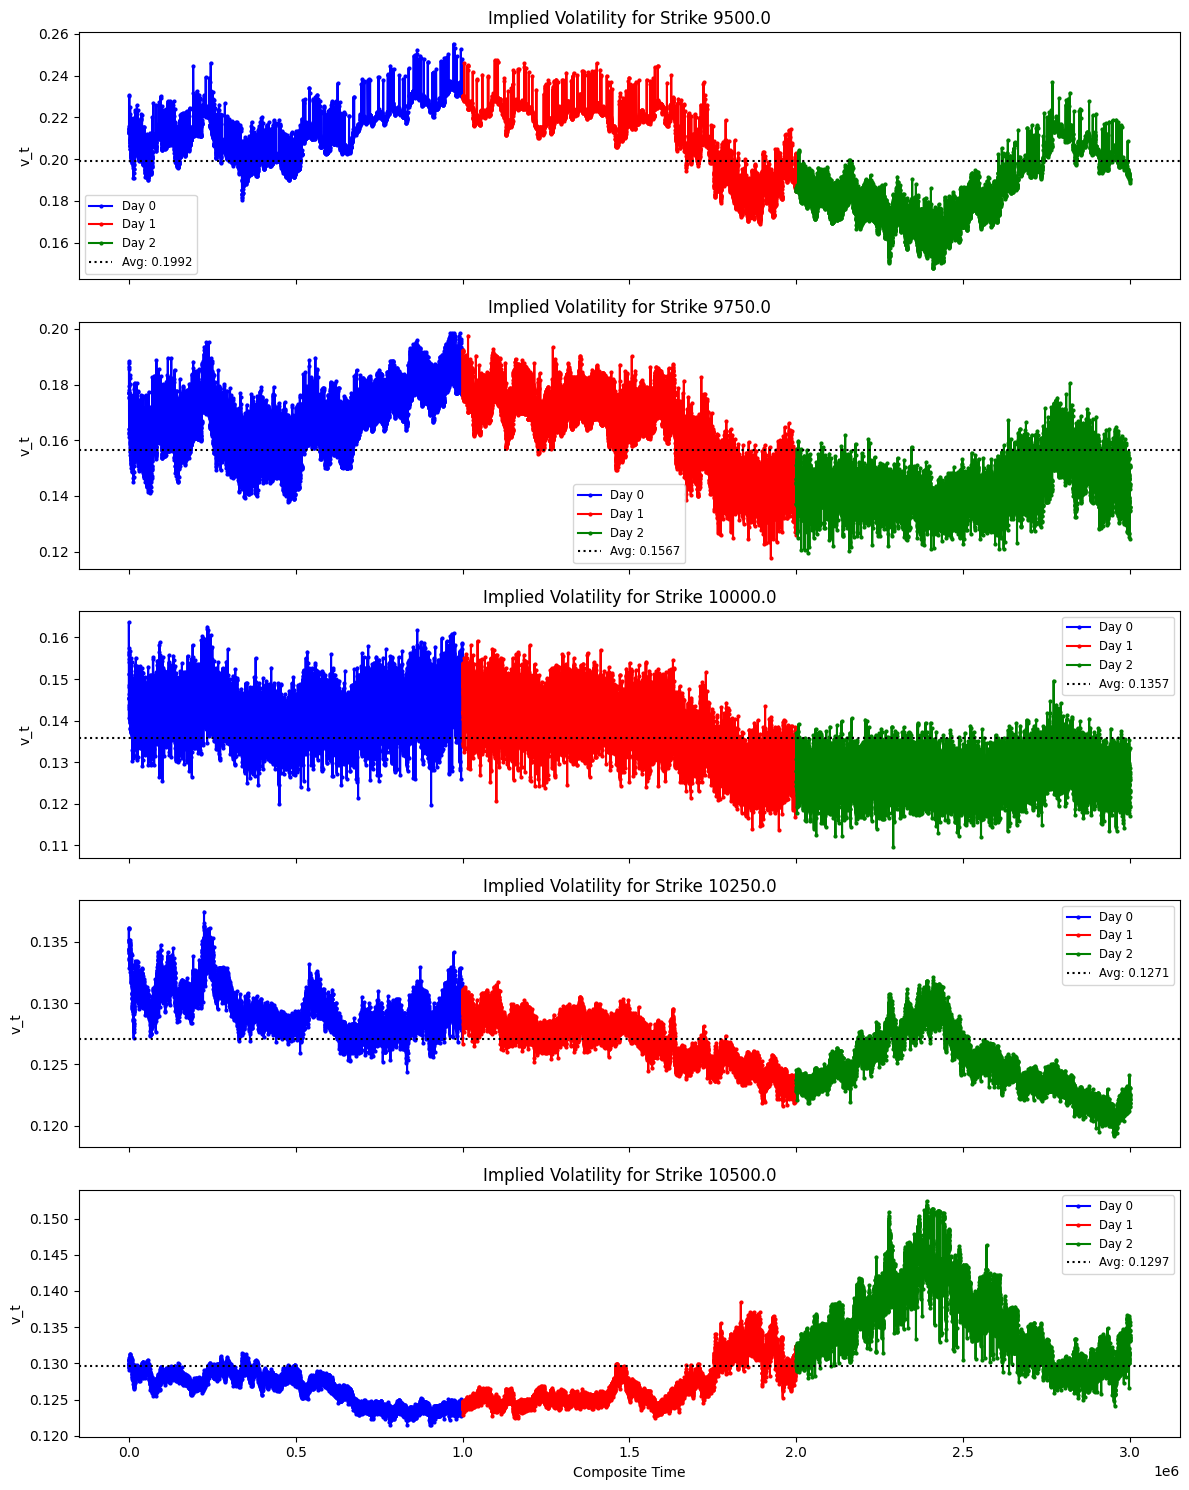

Done plotting IV time series with unsensible data removed.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy.stats import norm
from scipy.optimize import brentq
import time

try:
    from tqdm import tqdm
    tqdm.pandas()  # enable progress_apply for a nice progress bar
except ImportError:
    print("Please install tqdm via 'pip install tqdm' to enable progress bars.")
    pd.DataFrame.progress_apply = pd.DataFrame.apply  # fallback if tqdm isn't available

print("Starting IV time series plotting (with pre-downsampling and IV filtering).")

# ----------------------------------------------------------------------------
# 0) Check that df_merged exists (produced by your previous data merges) 
# ----------------------------------------------------------------------------
if 'df_merged' not in globals():
    print("Error: df_merged not found! Please ensure your data is preprocessed into df_merged.")
else:
    print(f"df_merged exists with {len(df_merged)} rows.")

# ----------------------------------------------------------------------------
# 1) Ensure TTE and m_t columns exist
# ----------------------------------------------------------------------------
def compute_TTE(day, timestamp):
    """
    TTE decays linearly from 8/250 at (day=0, timestamp=0) 
    to 7/250 at (day=0, timestamp=999000), etc.
    """
    return ((8 - day) - (timestamp / 999000)) / 250

if 'TTE' not in df_merged.columns:
    print("Computing TTE column...")
    df_merged['TTE'] = df_merged.apply(lambda row: compute_TTE(row['day'], row['timestamp']), axis=1)
    # Keep only rows with positive TTE
    df_merged = df_merged[df_merged['TTE'] > 0].copy()
    print("TTE computed; row count:", len(df_merged))

if 'm_t' not in df_merged.columns:
    print("Computing m_t column...")
    df_merged['m_t'] = df_merged.apply(lambda row: log(row['K'] / row['S_t']) / sqrt(row['TTE']), axis=1)
    print("m_t computed.")

# ----------------------------------------------------------------------------
# 2) Pre-downsample the data before computing v_t
# ----------------------------------------------------------------------------
pre_downsample_factor = 1  # Keep every 10th row (adjust as needed)
print(f"Pre-downsampling df_merged by factor of {pre_downsample_factor}...")

df_downsampled = df_merged.iloc[::pre_downsample_factor].copy()
print("Row count after pre-downsampling:", len(df_downsampled))

# ----------------------------------------------------------------------------
# 3) Compute v_t using a Black–Scholes implied vol function
# ----------------------------------------------------------------------------
def bs_call_price(S, K, T, sigma, r=0.0):
    if T <= 0 or sigma <= 0:
        return max(0, S - K)
    d1 = (log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def implied_volatility_call(price, S, K, T, r=0.0):
    def f(sigma):
        return bs_call_price(S, K, T, sigma, r) - price
    try:
        # Solve for sigma in [1e-6, 5.0]
        return brentq(f, 1e-6, 5.0, maxiter=200)
    except:
        return np.nan

print("Computing v_t (implied volatility) for pre-downsampled data...")
t0 = time.time()
df_downsampled['v_t'] = df_downsampled.progress_apply(
    lambda row: implied_volatility_call(row['V_t'], row['S_t'], row['K'], row['TTE'], r=0.0),
    axis=1
)
t1 = time.time()
print(f"v_t computed in {t1 - t0:.2f} seconds. Current row count: {len(df_downsampled)}")

# ----------------------------------------------------------------------------
# 4) Remove “unsensible” IV data points
#    (e.g. zero or negative, or extremely large)
# ----------------------------------------------------------------------------
# Adjust thresholds based on what's considered plausible for your scenario.
iv_lower_bound = 0.0001
iv_upper_bound = 2.0

mask = (df_downsampled['v_t'] > iv_lower_bound) & (df_downsampled['v_t'] < iv_upper_bound)
before_filter_count = len(df_downsampled)
df_downsampled = df_downsampled[mask].copy()
after_filter_count = len(df_downsampled)
print(f"Filtered out unsensible v_t values. Rows before: {before_filter_count}, after: {after_filter_count}.")

# ----------------------------------------------------------------------------
# 5) Compute composite time for plotting
# ----------------------------------------------------------------------------
max_ts = 999000
offset = 1000
df_downsampled['composite_time'] = df_downsampled['day'] * (max_ts + offset) + df_downsampled['timestamp']
print("Composite time computed. Final row count:", len(df_downsampled))

# ----------------------------------------------------------------------------
# 6) Plot IV time series (one subplot per strike)
# ----------------------------------------------------------------------------
unique_strikes = sorted(df_downsampled['K'].unique())
day_colors = {0: 'blue', 1: 'red', 2: 'green'}

fig, axs = plt.subplots(len(unique_strikes), 1, figsize=(12, 15), sharex=True)

for i, strike in enumerate(unique_strikes):
    ax = axs[i]
    strike_data = df_downsampled[df_downsampled['K'] == strike].sort_values('composite_time')
    for day in sorted(strike_data['day'].unique()):
        day_data = strike_data[strike_data['day'] == day]
        ax.plot(day_data['composite_time'], day_data['v_t'], marker='o', linestyle='-', markersize=2,
                color=day_colors.get(day, None), label=f"Day {day}")

    avg_iv = strike_data['v_t'].mean()
    ax.axhline(y=avg_iv, linestyle='dotted', color='black', label=f"Avg: {avg_iv:.4f}")
    ax.set_title(f"Implied Volatility for Strike {strike}")
    ax.set_ylabel("v_t")
    ax.legend(fontsize='small')

plt.xlabel("Composite Time")
plt.tight_layout()
plt.show()
print("Done plotting IV time series with unsensible data removed.")


Generating vol smile excerpts using full data (downsampling factor = 1) from df_downsampled.
Unique days found: [np.int64(0), np.int64(1), np.int64(2)]
Day 0 has 10000 unique timestamps.
Day 0 selected checkpoint timestamps: [0, 249900, 499900, 749900, 999900]
Day 0, timestamp 249900 skipped: only found 4 voucher strikes.
Day 0, timestamp 999900 skipped: only found 4 voucher strikes.


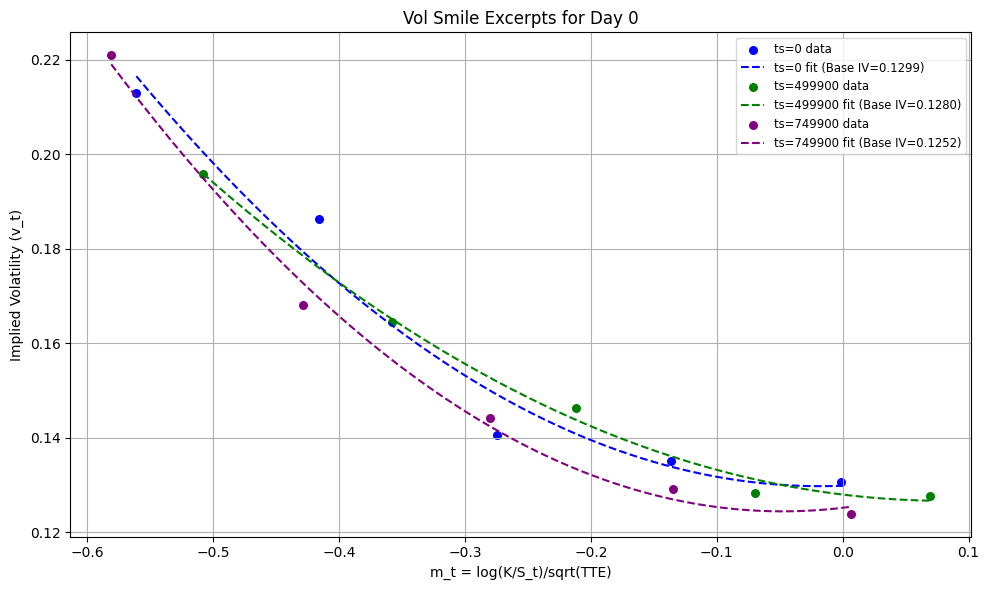

Day 1 has 10000 unique timestamps.
Day 1 selected checkpoint timestamps: [0, 249900, 499900, 749900, 999900]
Day 1, timestamp 0 skipped: only found 4 voucher strikes.
Day 1, timestamp 499900 skipped: only found 4 voucher strikes.


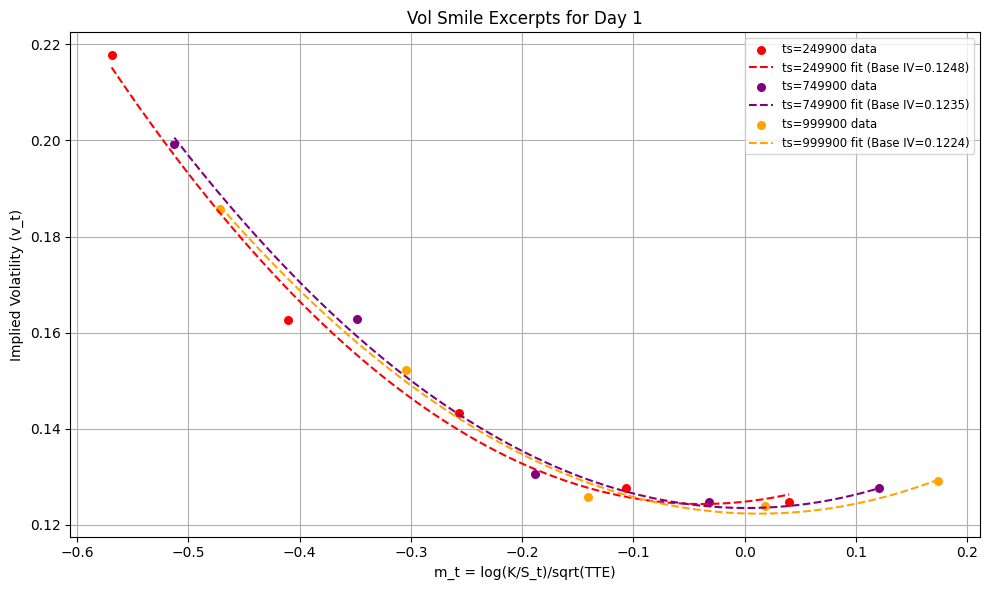

Day 2 has 10000 unique timestamps.
Day 2 selected checkpoint timestamps: [0, 249900, 499900, 749900, 999900]
Day 2, timestamp 0 skipped: only found 4 voucher strikes.
Day 2, timestamp 749900 skipped: only found 4 voucher strikes.
Day 2, timestamp 999900 skipped: only found 4 voucher strikes.


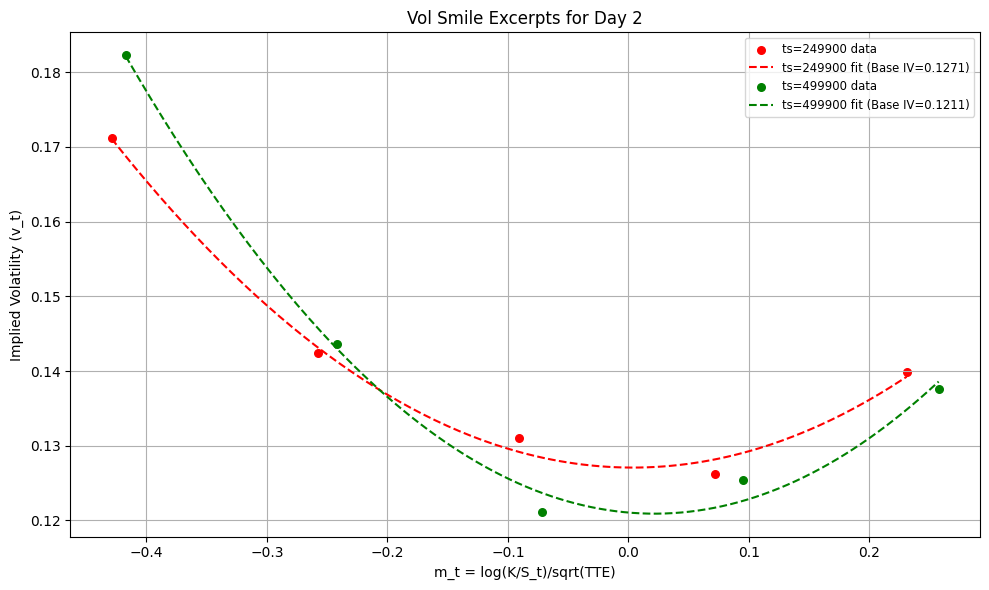

Finished generating vol smile excerpts for each day.


In [20]:
import numpy as np
import matplotlib.pyplot as plt

print("Generating vol smile excerpts using full data (downsampling factor = 1) from df_downsampled.")

# Use the full data stored in df_downsampled (which should have v_t, m_t, K, etc.)
unique_days = sorted(df_downsampled['day'].unique())
print("Unique days found:", unique_days)

for day in unique_days:
    day_data = df_downsampled[df_downsampled['day'] == day]
    # Get all unique timestamps for the day, sorted in increasing order.
    unique_ts = np.sort(day_data['timestamp'].unique())
    n_ts = len(unique_ts)
    print(f"Day {day} has {n_ts} unique timestamps.")
    
    if n_ts < 5:
        print(f"Not enough timestamps for day {day} to select 5 checkpoints. Skipping day {day}.")
        continue

    # Select 5 equally spaced checkpoint timestamps.
    checkpoint_indices = np.linspace(0, n_ts - 1, 5, dtype=int)
    selected_ts = unique_ts[checkpoint_indices]
    print(f"Day {day} selected checkpoint timestamps: {selected_ts.tolist()}")

    # Create one figure for the day; all 5 vol smiles will be overlaid on one axis.
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Define a list of colors for the different checkpoints.
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for i, ts in enumerate(selected_ts):
        subset = day_data[day_data['timestamp'] == ts]
        
        # Only process this checkpoint if all 5 voucher strikes are present.
        if subset['K'].nunique() < 5:
            print(f"Day {day}, timestamp {ts} skipped: only found {subset['K'].nunique()} voucher strikes.")
            continue
        
        # Extract the transformed m_t values and the computed v_t values.
        m_vals = subset['m_t'].values
        v_vals = subset['v_t'].values
        
        # Fit a quadratic (parabolic) curve: v_t = a*m_t^2 + b*m_t + c.
        coeffs = np.polyfit(m_vals, v_vals, 2)
        a, b, c = coeffs
        base_iv = c  # The intercept is defined as the base IV.
        
        cp_color = colors[i % len(colors)]
        ax.scatter(m_vals, v_vals, color=cp_color, s=30, label=f"ts={ts} data")
        m_range = np.linspace(min(m_vals), max(m_vals), 200)
        ax.plot(m_range, a * m_range**2 + b * m_range + c, linestyle='--', 
                color=cp_color, label=f"ts={ts} fit (Base IV={base_iv:.4f})")
    
    ax.set_title(f"Vol Smile Excerpts for Day {day}")
    ax.set_xlabel("m_t = log(K/S_t)/sqrt(TTE)")
    ax.set_ylabel("Implied Volatility (v_t)")
    ax.legend(fontsize='small', loc='best')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

print("Finished generating vol smile excerpts for each day.")


v_t not found in df_merged; using df_downsampled as the data source for base IV computation.
Total groups (day, timestamp): 30000
Processing every 10th group from the total groups.


Computing Base IV Time Series: 100%|█████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1299.82it/s]


Base IV records computed: 1749 entries.


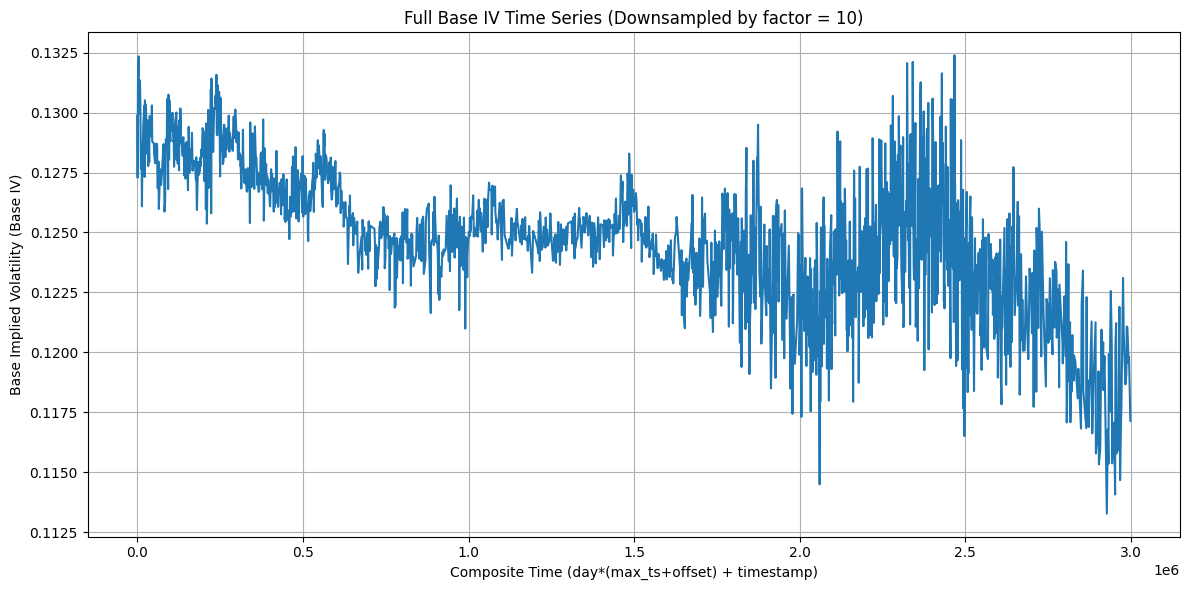

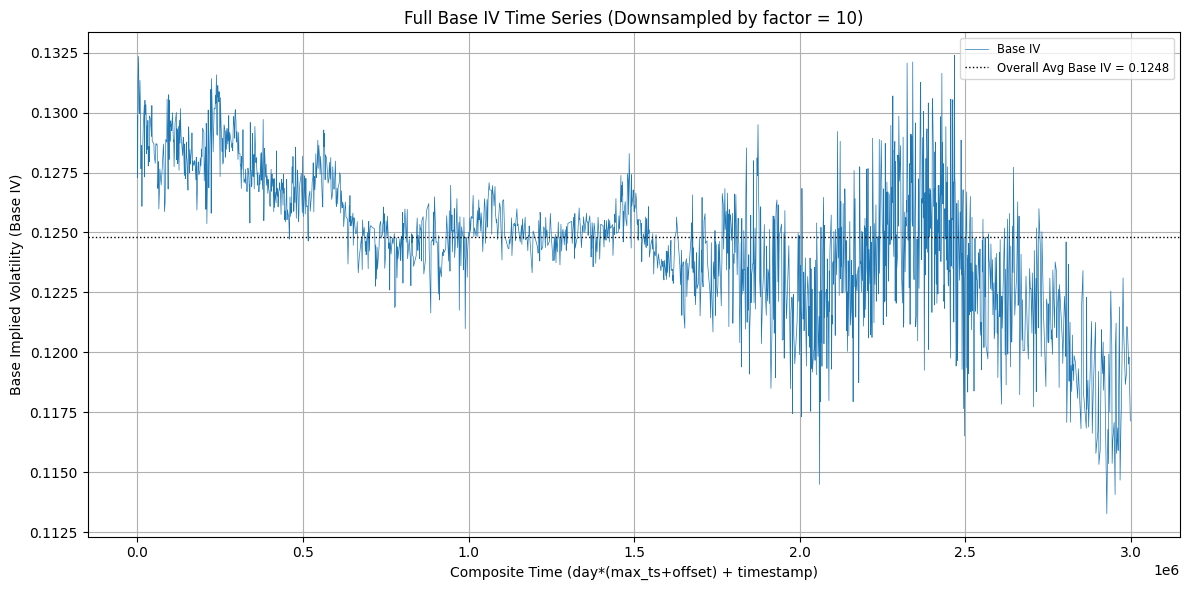

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

# ---------------------------
# Determine the source DataFrame for base IV computation.
# ---------------------------
if 'v_t' in df_merged.columns:
    source_df = df_merged.copy()
    print("Using df_merged as the data source for base IV computation.")
elif 'df_downsampled' in globals():
    source_df = df_downsampled.copy()
    print("v_t not found in df_merged; using df_downsampled as the data source for base IV computation.")
else:
    raise Exception("No computed v_t found in either df_merged or df_downsampled.")

# ---------------------------
# Ensure that composite_time is present in the source data.
# ---------------------------
max_ts = 999000
offset = 1000
if 'composite_time' not in source_df.columns:
    source_df['composite_time'] = source_df['day'] * (max_ts + offset) + source_df['timestamp']
    print("Composite time column computed in the source data.")

# ---------------------------
# Group the source data by (day, timestamp)
# ---------------------------
grouped = source_df.groupby(['day', 'timestamp'])
keys = sorted(grouped.groups.keys())
print("Total groups (day, timestamp):", len(keys))

# ---------------------------
# Downsampling parameter (process every nth group)
# ---------------------------
downsample_factor = 10  # Adjust as needed to reduce computation
print(f"Processing every {downsample_factor}th group from the total groups.")

base_iv_records = []  # This list will collect (day, timestamp, base_iv)

# Loop over groups with downsampling
for key in tqdm(keys[::downsample_factor], desc="Computing Base IV Time Series"):
    day_val, ts_val = key
    group = grouped.get_group(key)
    # Check that this group contains all 5 distinct voucher strikes.
    if group['K'].nunique() == 5:
        # Extract the transformed variable (m_t) and computed v_t values.
        m_vals = group['m_t'].values
        try:
            v_vals = group['v_t'].values  # May raise KeyError if missing
        except KeyError:
            print(f"Group {key} missing v_t values; skipping.")
            continue
        # Fit a quadratic curve: v_t = a * m_t^2 + b * m_t + c.
        try:
            coeffs = np.polyfit(m_vals, v_vals, 2)
        except Exception as e:
            print(f"Polyfit failed for group {key} with error: {e}; skipping.")
            continue
        a, b, c = coeffs
        base_iv_records.append((day_val, ts_val, c))

# Convert the records into a DataFrame.
df_base_iv = pd.DataFrame(base_iv_records, columns=['day', 'timestamp', 'base_iv'])
df_base_iv['composite_time'] = df_base_iv['day'] * (max_ts + offset) + df_base_iv['timestamp']
print("Base IV records computed:", len(df_base_iv), "entries.")

# ---------------------------
# Plot the full Base IV time series.
# ---------------------------
plt.figure(figsize=(12, 6))
plt.plot(df_base_iv['composite_time'], df_base_iv['base_iv'], linestyle='-', markersize=0.5)
plt.xlabel("Composite Time (day*(max_ts+offset) + timestamp)")
plt.ylabel("Base Implied Volatility (Base IV)")
plt.title("Full Base IV Time Series (Downsampled by factor = {})".format(downsample_factor))
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot the full Base IV time series with adjustments.
# ---------------------------
plt.figure(figsize=(12, 6))
plt.plot(df_base_iv['composite_time'], df_base_iv['base_iv'],
         linestyle='-', linewidth=0.5, label="Base IV")
avg_base_iv = df_base_iv['base_iv'].mean()
plt.axhline(y=avg_base_iv, color='black', linestyle=':', linewidth=1,
            label=f"Overall Avg Base IV = {avg_base_iv:.4f}")
plt.xlabel("Composite Time (day*(max_ts+offset) + timestamp)")
plt.ylabel("Base Implied Volatility (Base IV)")
plt.title("Full Base IV Time Series (Downsampled by factor = {})".format(downsample_factor))
plt.grid(True)
plt.legend(fontsize='small')
plt.tight_layout()
plt.show()


v_t not found in df_merged; using df_downsampled as the data source for the fit.
Fitted coefficients (with c fixed = 0.125):
a = 0.280227
b = 0.003789
c (fixed) = 0.125000


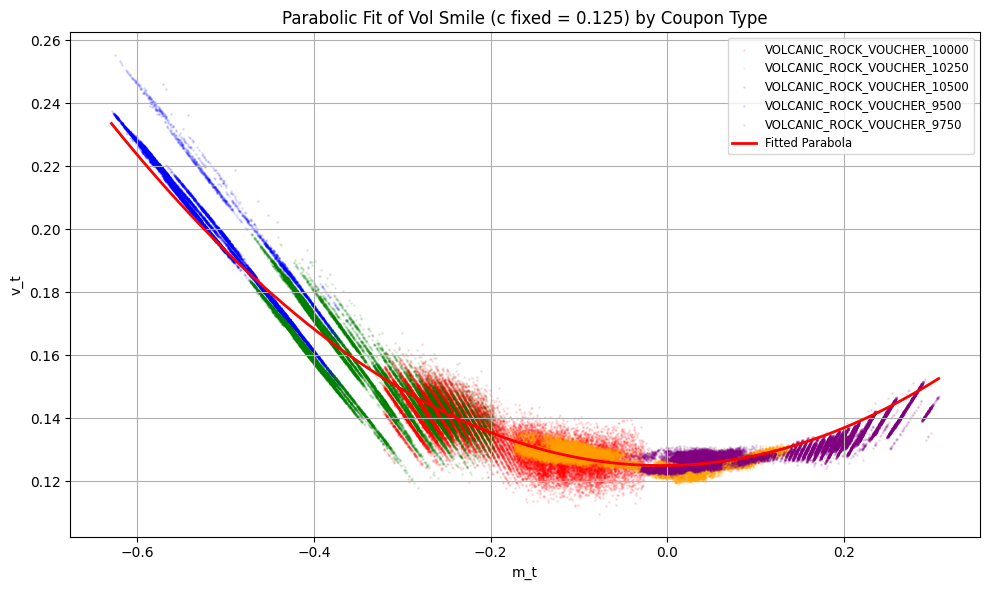

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Determine the data source: use df_merged if it contains 'v_t',
# otherwise use df_downsampled.
# --------------------------------------------------------------
if 'v_t' in df_merged.columns:
    source_df = df_merged
    print("Using df_merged as the data source for the fit.")
elif 'df_downsampled' in globals():
    source_df = df_downsampled
    print("v_t not found in df_merged; using df_downsampled as the data source for the fit.")
else:
    raise Exception("No source found with computed v_t.")

# --------------------------------------------------------------
# Extract m_t and v_t values.
# --------------------------------------------------------------
x = source_df['m_t'].values   # m_t values
v = source_df['v_t'].values   # corresponding v_t values

# --------------------------------------------------------------
# Fixed intercept c.
# --------------------------------------------------------------
c_fixed = 0.125

# Create adjusted target y = v_t - c_fixed
y = v - c_fixed

# --------------------------------------------------------------
# Build design matrix for m_t^2 and m_t terms.
# --------------------------------------------------------------
X = np.column_stack((x**2, x))

# --------------------------------------------------------------
# Solve the least squares problem to find coefficients a and b.
# --------------------------------------------------------------
coeffs, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
a, b = coeffs

print(f"Fitted coefficients (with c fixed = {c_fixed}):")
print(f"a = {a:.6f}")
print(f"b = {b:.6f}")
print(f"c (fixed) = {c_fixed:.6f}")

# --------------------------------------------------------------
# Generate a range of m_t values for plotting the fitted curve.
# --------------------------------------------------------------
x_range = np.linspace(np.min(x), np.max(x), 400)
v_fit = a * x_range**2 + b * x_range + c_fixed

# --------------------------------------------------------------
# Create color mapping for voucher types.
# --------------------------------------------------------------
color_map = {
    "VOLCANIC_ROCK_VOUCHER_9500": "blue",
    "VOLCANIC_ROCK_VOUCHER_9750": "green",
    "VOLCANIC_ROCK_VOUCHER_10000": "red",
    "VOLCANIC_ROCK_VOUCHER_10250": "orange",
    "VOLCANIC_ROCK_VOUCHER_10500": "purple",
    # You can specify more colors if there are additional product types.
}

# --------------------------------------------------------------
# Plot the scatter data with color coding for coupon type and the fitted curve.
# --------------------------------------------------------------
plt.figure(figsize=(10,6))

# Group by the 'product' column and scatter the points using different colors.
for prod, group in source_df.groupby("product"):
    # Only plot the voucher products with the specified naming pattern.
    if prod.startswith("VOLCANIC_ROCK_VOUCHER"):
        plt.scatter(group["m_t"], group["v_t"], s=1, alpha=0.1, 
                    color=color_map.get(prod, "gray"), label=prod)
    else:
        # For any other products (like the underlying), plot in black.
        plt.scatter(group["m_t"], group["v_t"], s=1, alpha=0.1, 
                    color="black", label=prod)

# Plot the fitted parabolic curve in red.
plt.plot(x_range, v_fit, color='red', linewidth=2, label="Fitted Parabola")
plt.xlabel("m_t")
plt.ylabel("v_t")
plt.title("Parabolic Fit of Vol Smile (c fixed = 0.125) by Coupon Type")
plt.legend(fontsize='small', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


v_t not found in df_merged; using df_downsampled as the data source for the fit.
Fitted coefficients (with c fixed = 0.125):
a = 0.364484
b = 0.043251
c (fixed) = 0.125000


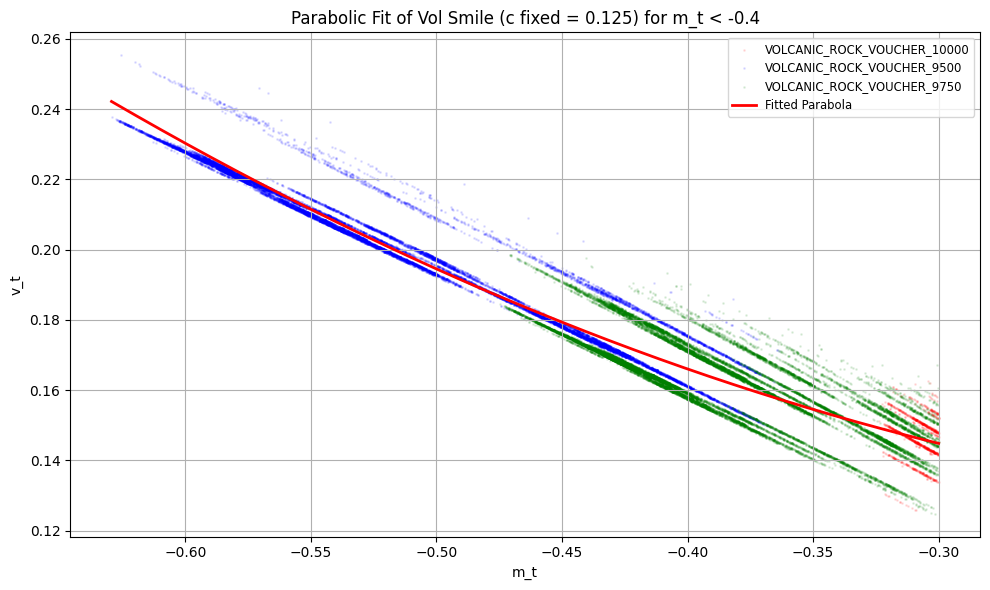

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Determine the data source: use df_merged if it contains 'v_t',
# otherwise use df_downsampled.
# --------------------------------------------------------------
if 'df_merged' in globals() and ('v_t' in df_merged.columns or 'price' in df_merged.columns):
    source_df = df_merged.copy()
    print("Using df_merged as the data source for the fit.")
elif 'df_downsampled' in globals() and ('v_t' in df_downsampled.columns or 'price' in df_downsampled.columns):
    source_df = df_downsampled.copy()
    print("v_t not found in df_merged; using df_downsampled as the data source for the fit.")
else:
    raise Exception("No source found with computed v_t or price column.")

# If v_t doesn't exist, try to compute it from price (if that's applicable)
if 'v_t' not in source_df.columns:
    if 'price' in source_df.columns:
        source_df['v_t'] = source_df['price']
    else:
        raise Exception("Neither v_t nor price exists in source_df.")

# --------------------------------------------------------------
# Limit the view to points where m_t < -0.4.
# --------------------------------------------------------------
filtered_df = source_df[source_df['m_t'] < -0.3].copy()
if filtered_df.empty:
    raise Exception("No data found with m_t < -0.4.")

# --------------------------------------------------------------
# Extract m_t and v_t values from the filtered data.
# --------------------------------------------------------------
x = filtered_df['m_t'].values   # m_t values
v = filtered_df['v_t'].values   # corresponding v_t values

# --------------------------------------------------------------
# Fixed intercept c.
# --------------------------------------------------------------
c_fixed = 0.125

# Create adjusted target y = v_t - c_fixed
y = v - c_fixed

# --------------------------------------------------------------
# Build design matrix for m_t^2 and m_t terms.
# --------------------------------------------------------------
X = np.column_stack((x**2, x))

# --------------------------------------------------------------
# Solve the least squares problem to find coefficients a and b.
# --------------------------------------------------------------
coeffs, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
a, b = coeffs

print(f"Fitted coefficients (with c fixed = {c_fixed}):")
print(f"a = {a:.6f}")
print(f"b = {b:.6f}")
print(f"c (fixed) = {c_fixed:.6f}")

# --------------------------------------------------------------
# Generate a range of m_t values for plotting the fitted curve.
# We'll use the range from min(x) to max(x) from the filtered data.
# --------------------------------------------------------------
x_range = np.linspace(np.min(x), np.max(x), 400)
v_fit = a * x_range**2 + b * x_range + c_fixed

# --------------------------------------------------------------
# Create color mapping for voucher types.
# --------------------------------------------------------------
color_map = {
    "VOLCANIC_ROCK_VOUCHER_9500": "blue",
    "VOLCANIC_ROCK_VOUCHER_9750": "green",
    "VOLCANIC_ROCK_VOUCHER_10000": "red",
    "VOLCANIC_ROCK_VOUCHER_10250": "orange",
    "VOLCANIC_ROCK_VOUCHER_10500": "purple",
    # Underlying or other products in black:
    "VOLCANIC_ROCK": "black",
}

# --------------------------------------------------------------
# Plot the scatter data with color coding for coupon type and the fitted curve.
# --------------------------------------------------------------
plt.figure(figsize=(10,6))

# Group by the 'product' column and scatter the points using different colors.
for prod, group in filtered_df.groupby("product"):
    plt.scatter(group["m_t"], group["v_t"], s=1, alpha=0.1, 
                color=color_map.get(prod, "gray"), label=prod)

# Plot the fitted parabolic curve in red.
plt.plot(x_range, v_fit, color='red', linewidth=2, label="Fitted Parabola")
plt.xlabel("m_t")
plt.ylabel("v_t")
plt.title("Parabolic Fit of Vol Smile (c fixed = 0.125) for m_t < -0.4")
plt.legend(fontsize='small', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Using df_downsampled as the data source.


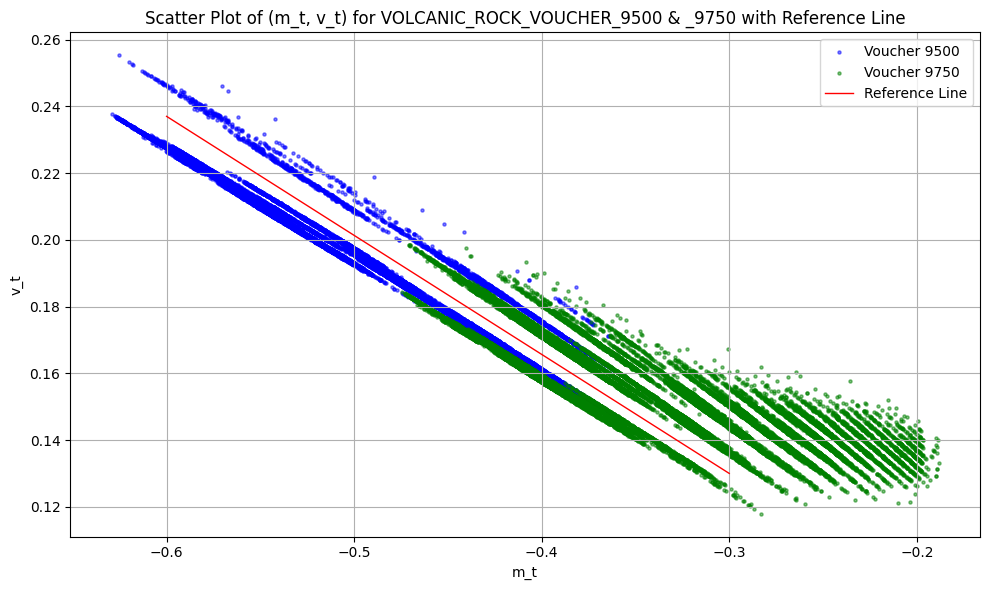

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to use df_merged first; if it doesn't have the required columns, then fall back to df_downsampled.
if 'df_merged' in globals() and ('v_t' in df_merged.columns or 'price' in df_merged.columns):
    source_df = df_merged.copy()
    print("Using df_merged as the data source.")
elif 'df_downsampled' in globals() and ('v_t' in df_downsampled.columns or 'price' in df_downsampled.columns):
    source_df = df_downsampled.copy()
    print("Using df_downsampled as the data source.")
else:
    raise Exception("Neither df_merged nor df_downsampled has a 'v_t' or 'price' column. Please check your data.")

# Ensure we have a column named 'v_t'. If not, check if we can use 'price' as a fallback.
if 'v_t' not in source_df.columns:
    if 'price' in source_df.columns:
        source_df['v_t'] = source_df['price']
        print("Column 'v_t' not found; using 'price' as v_t.")
    else:
        raise Exception("Source data lacks both 'v_t' and 'price' columns.")

# --- Filter for vouchers 9500 and 9750 ---
voucher_9500 = source_df[source_df['product'] == "VOLCANIC_ROCK_VOUCHER_9500"]
voucher_9750 = source_df[source_df['product'] == "VOLCANIC_ROCK_VOUCHER_9750"]

# --- Prepare the reference line points ---
x_line = np.array([-0.6, -0.3])
y_line = np.array([0.237, 0.13])

# --- Create the plot ---
plt.figure(figsize=(10, 6))

# Scatter plot for voucher 9500 (blue)
plt.scatter(voucher_9500['m_t'], voucher_9500['v_t'], s=5, alpha=0.5,
            color='blue', label="Voucher 9500")

# Scatter plot for voucher 9750 (green)
plt.scatter(voucher_9750['m_t'], voucher_9750['v_t'], s=5, alpha=0.5,
            color='green', label="Voucher 9750")

# Plot the reference line (red)
plt.plot(x_line, y_line, color='red', linestyle='-', linewidth=1, label="Reference Line")

plt.xlabel("m_t")
plt.ylabel("v_t")
plt.title("Scatter Plot of (m_t, v_t) for VOLCANIC_ROCK_VOUCHER_9500 & _9750 with Reference Line")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Using df_downsampled as data source for the histogram.
Number of voucher rows: 135152
Standard deviation of IV differences: 0.004922


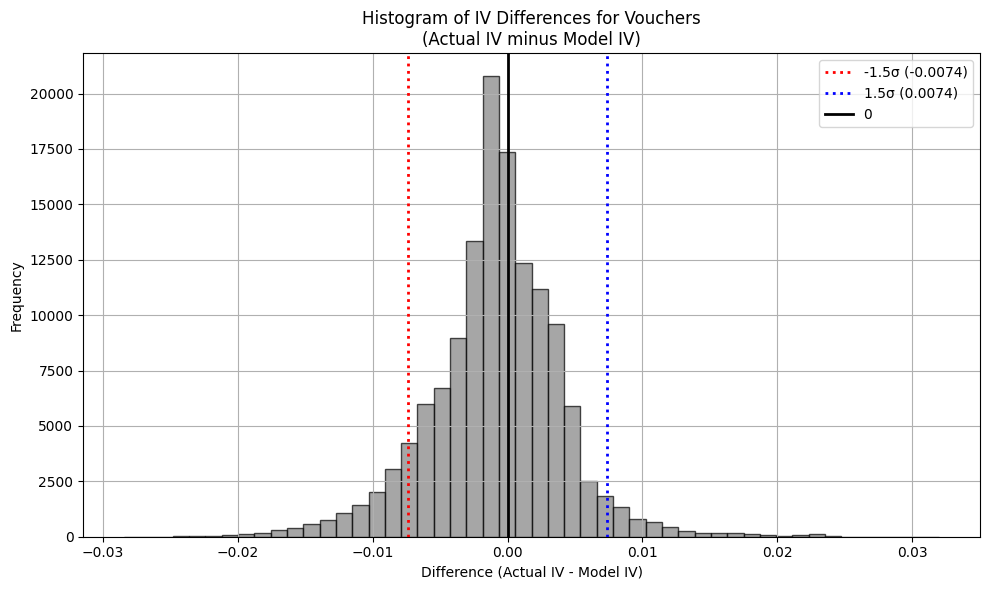

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Determine the data source: use df_merged if available.
# ---------------------------
if 'v_t' in df_merged.columns and 'm_t' in df_merged.columns:
    source_df = df_merged.copy()
    print("Using df_merged as data source for the histogram.")
elif 'df_downsampled' in globals() and 'v_t' in df_downsampled.columns and 'm_t' in df_downsampled.columns:
    source_df = df_downsampled.copy()
    print("Using df_downsampled as data source for the histogram.")
else:
    raise Exception("No data with 'v_t' and 'm_t' found in df_merged or df_downsampled.")

# ---------------------------
# Filter data for the vouchers only.
# Assume that voucher product names start with "VOLCANIC_ROCK_VOUCHER_".
# ---------------------------
voucher_mask = source_df['product'].str.startswith("VOLCANIC_ROCK_VOUCHER_")
voucher_data = source_df[voucher_mask].copy()
print("Number of voucher rows:", len(voucher_data))

# ---------------------------
# Define the fixed parameters for the quadratic model.
# Model: v_t = a * m_t^2 + b * m_t + c, with fixed c = 0.125.
# ---------------------------
a = 0.280227
b = 0.003789
c = 0.125000

# Compute the model IV based on m_t:
voucher_data['v_model'] = a * voucher_data['m_t']**2 + b * voucher_data['m_t'] + c

# Compute the difference between actual and model IV.
voucher_data['iv_diff'] = voucher_data['v_t'] - voucher_data['v_model']

# Compute the standard deviation of these differences.
std_diff = voucher_data['iv_diff'].std()
print(f"Standard deviation of IV differences: {std_diff:.6f}")

# ---------------------------
# Adjustable standard deviation multiplier.
# ---------------------------
std_multiplier = 1.5   # Change this value as desired (default is 0.5)

# ---------------------------
# Plot histogram of IV differences.
# ---------------------------
plt.figure(figsize=(10, 6))
plt.hist(voucher_data['iv_diff'], bins=50, color='gray', alpha=0.7, edgecolor='black')
plt.axvline(x=-std_multiplier*std_diff, color='red', linestyle='dotted', linewidth=2, 
            label=f"-{std_multiplier}σ ({-std_multiplier*std_diff:.4f})")
plt.axvline(x=std_multiplier*std_diff, color='blue', linestyle='dotted', linewidth=2, 
            label=f"{std_multiplier}σ ({std_multiplier*std_diff:.4f})")
plt.axvline(x=0, color='black', linestyle='solid', linewidth=2, label="0")
plt.xlabel("Difference (Actual IV - Model IV)")
plt.ylabel("Frequency")
plt.title("Histogram of IV Differences for Vouchers\n(Actual IV minus Model IV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Using df_downsampled as data source for grouping.
Number of voucher rows: 135152

IV Difference statistics by voucher:
                       product      mean       std        5%       25%  \
0  VOLCANIC_ROCK_VOUCHER_10000 -0.001192  0.005026 -0.009487 -0.004392   
1  VOLCANIC_ROCK_VOUCHER_10250 -0.000298  0.001971 -0.003161 -0.001644   
2  VOLCANIC_ROCK_VOUCHER_10500 -0.001321  0.002884 -0.006570 -0.002970   
3   VOLCANIC_ROCK_VOUCHER_9500  0.002578  0.005407 -0.005658 -0.000142   
4   VOLCANIC_ROCK_VOUCHER_9750 -0.002865  0.006859 -0.013921 -0.007456   

        75%       95%  
0  0.002205  0.006860  
1  0.000841  0.003386  
2  0.000462  0.003188  
3  0.004417  0.013621  
4  0.002111  0.008503  


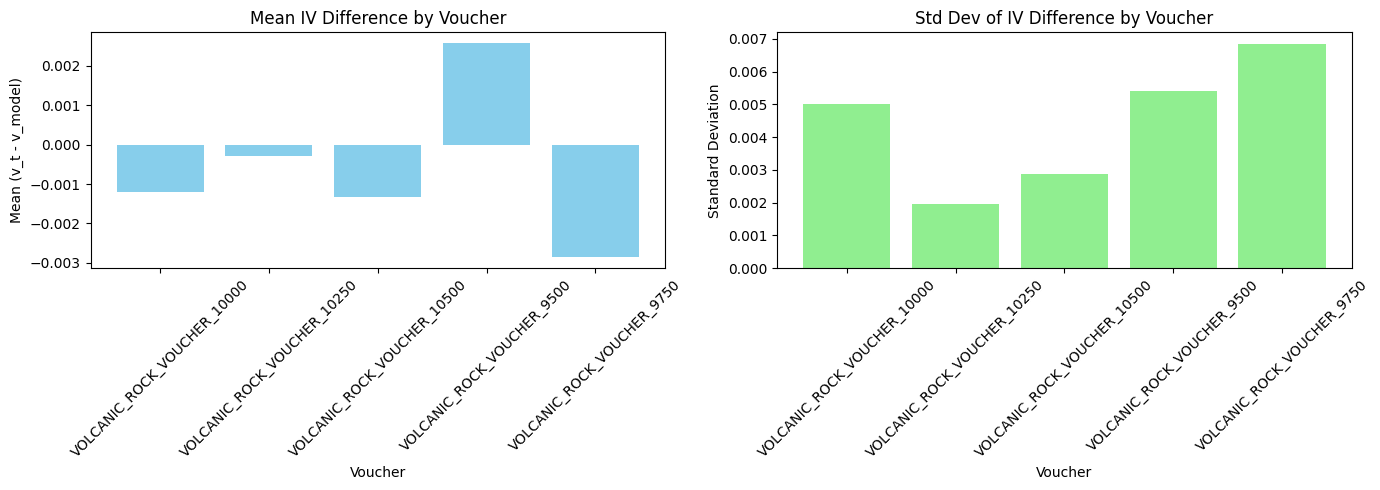

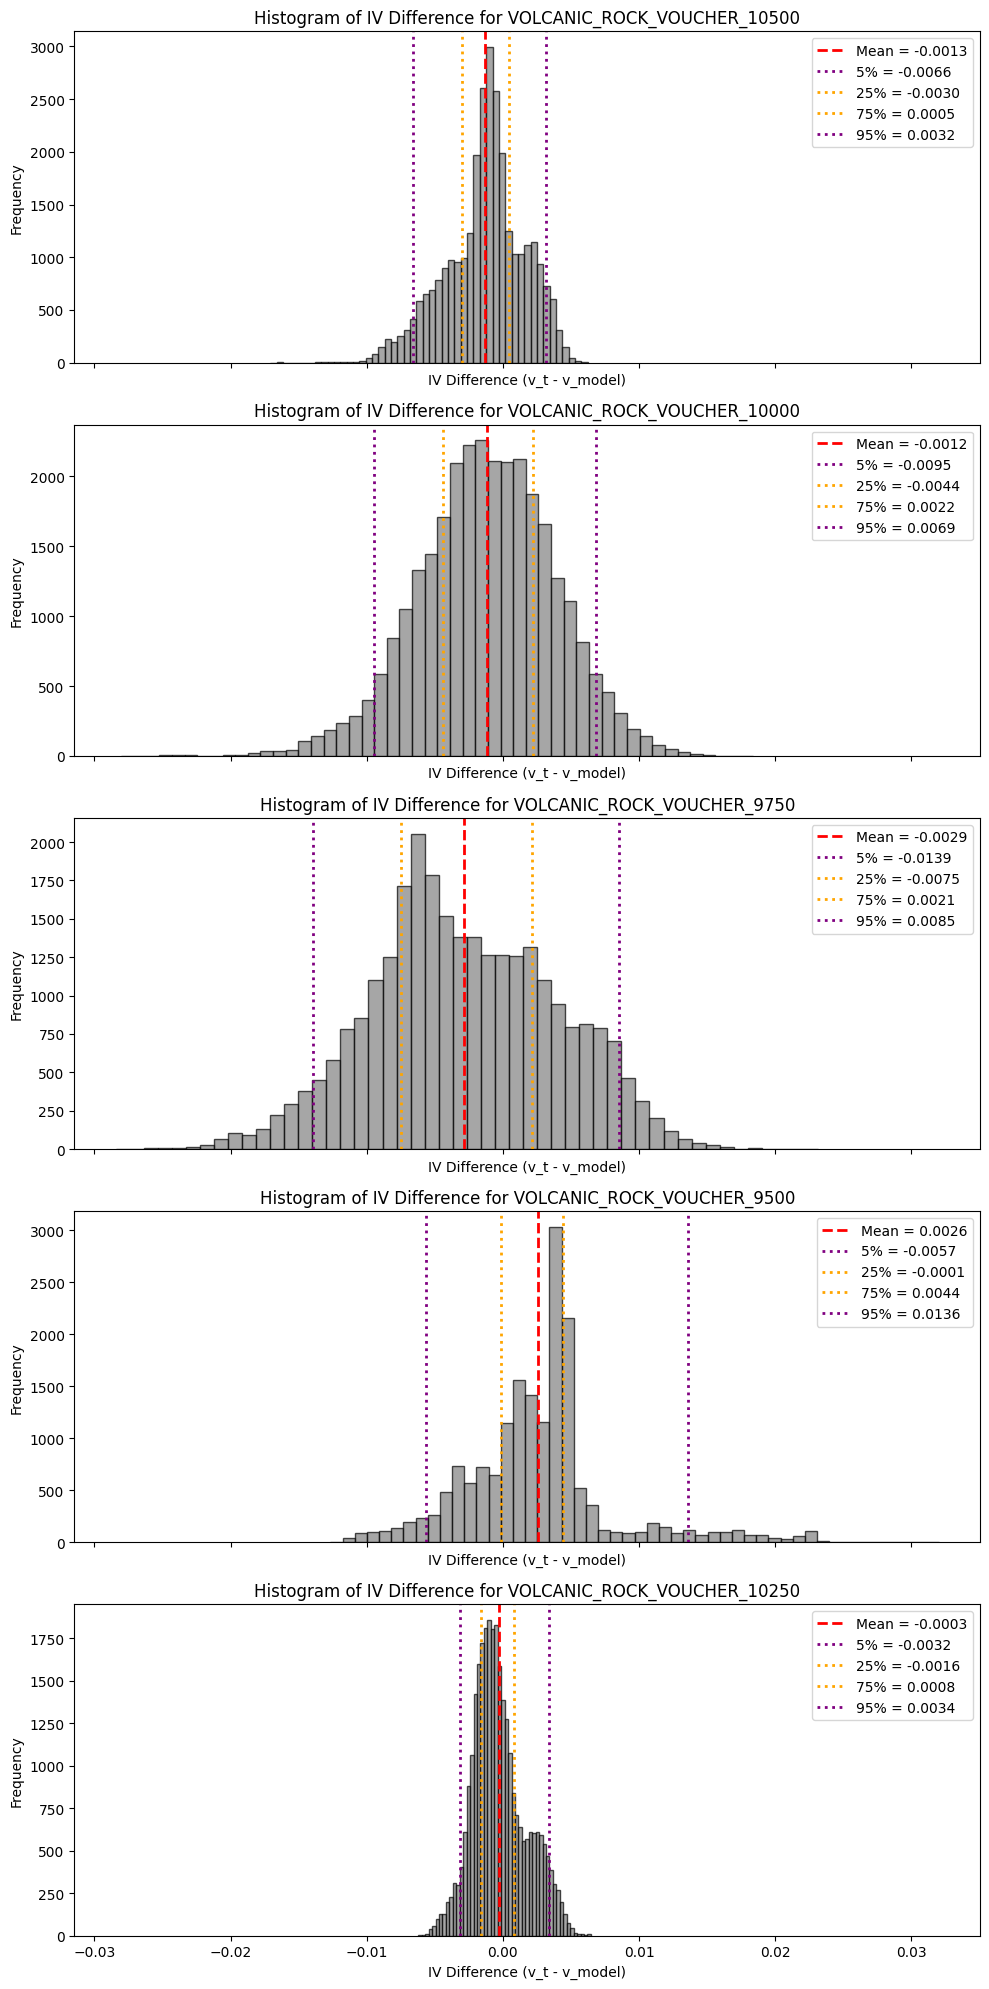

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# Determine the data source.
# ---------------------------
if 'v_t' in df_merged.columns and 'm_t' in df_merged.columns:
    source_df = df_merged.copy()
    print("Using df_merged as data source for grouping.")
elif 'df_downsampled' in globals() and 'v_t' in df_downsampled.columns and 'm_t' in df_downsampled.columns:
    source_df = df_downsampled.copy()
    print("Using df_downsampled as data source for grouping.")
else:
    raise Exception("No data with 'v_t' and 'm_t' found in df_merged or df_downsampled.")

# ---------------------------
# Filter voucher data.
# ---------------------------
voucher_mask = source_df['product'].str.startswith("VOLCANIC_ROCK_VOUCHER_")
voucher_data = source_df[voucher_mask].copy()
print("Number of voucher rows:", len(voucher_data))

# ---------------------------
# Define fixed quadratic model parameters.
# Model: v_t = a*m_t^2 + b*m_t + c, with c fixed at 0.125.
# ---------------------------
a = 0.280227
b = 0.003789
c = 0.125000

# Compute model IV and the IV difference (spread).
voucher_data['v_model'] = a * voucher_data['m_t']**2 + b * voucher_data['m_t'] + c
voucher_data['iv_diff'] = voucher_data['v_t'] - voucher_data['v_model']

# ---------------------------
# Compute aggregate statistics by voucher.
# ---------------------------
group_stats = voucher_data.groupby('product')['iv_diff'].agg(['mean', 'std']).reset_index()
percentiles = voucher_data.groupby('product')['iv_diff'].quantile([0.05, 0.25, 0.75, 0.95]).unstack()
group_stats = group_stats.merge(percentiles, on='product')
group_stats.rename(columns={0.05: "5%", 0.25: "25%", 0.75: "75%", 0.95: "95%"}, inplace=True)

print("\nIV Difference statistics by voucher:")
print(group_stats)

# ---------------------------
# Optional: Plot bar charts for mean and standard deviation.
# ---------------------------
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].bar(group_stats['product'], group_stats['mean'], color='skyblue')
ax[0].set_title("Mean IV Difference by Voucher")
ax[0].set_xlabel("Voucher")
ax[0].set_ylabel("Mean (v_t - v_model)")
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(group_stats['product'], group_stats['std'], color='lightgreen')
ax[1].set_title("Std Dev of IV Difference by Voucher")
ax[1].set_xlabel("Voucher")
ax[1].set_ylabel("Standard Deviation")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ---------------------------
# Plot histogram for each voucher.
# ---------------------------
unique_vouchers = voucher_data['product'].unique()
n_vouchers = len(unique_vouchers)
fig, axs = plt.subplots(n_vouchers, 1, figsize=(10, 4 * n_vouchers), sharex=True)

# Ensure axs is iterable when there's only one voucher.
if n_vouchers == 1:
    axs = [axs]

for ax, voucher in zip(axs, unique_vouchers):
    v_data = voucher_data[voucher_data['product'] == voucher]['iv_diff']
    mean_val = v_data.mean()
    std_val = v_data.std()
    percs = np.percentile(v_data, [5, 25, 75, 95])
    
    ax.hist(v_data, bins=50, color='gray', alpha=0.7, edgecolor='black')
    
    # Plot vertical lines for mean and percentiles.
    ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f"Mean = {mean_val:.4f}")
    ax.axvline(percs[0], color='purple', linestyle='dotted', linewidth=2, label=f"5% = {percs[0]:.4f}")
    ax.axvline(percs[1], color='orange', linestyle='dotted', linewidth=2, label=f"25% = {percs[1]:.4f}")
    ax.axvline(percs[2], color='orange', linestyle='dotted', linewidth=2, label=f"75% = {percs[2]:.4f}")
    ax.axvline(percs[3], color='purple', linestyle='dotted', linewidth=2, label=f"95% = {percs[3]:.4f}")
    
    ax.set_title(f"Histogram of IV Difference for {voucher}")
    ax.set_xlabel("IV Difference (v_t - v_model)")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()


Using df_downsampled as data source for rolling average IV spread.
Number of voucher rows: 135152

Product: VOLCANIC_ROCK_VOUCHER_10000
0.05   -0.004153
0.25   -0.002571
0.75    0.000244
0.95    0.001973
Name: rolling_iv_diff, dtype: float64

Product: VOLCANIC_ROCK_VOUCHER_10250
0.05   -0.002988
0.25   -0.001543
0.75    0.000492
0.95    0.003317
Name: rolling_iv_diff, dtype: float64

Product: VOLCANIC_ROCK_VOUCHER_10500
0.05   -0.005663
0.25   -0.003271
0.75    0.000176
0.95    0.003163
Name: rolling_iv_diff, dtype: float64

Product: VOLCANIC_ROCK_VOUCHER_9500
0.05   -0.001794
0.25    0.000687
0.75    0.004617
0.95    0.005661
Name: rolling_iv_diff, dtype: float64

Product: VOLCANIC_ROCK_VOUCHER_9750
0.05   -0.005856
0.25   -0.004012
0.75   -0.001616
0.95   -0.000290
Name: rolling_iv_diff, dtype: float64


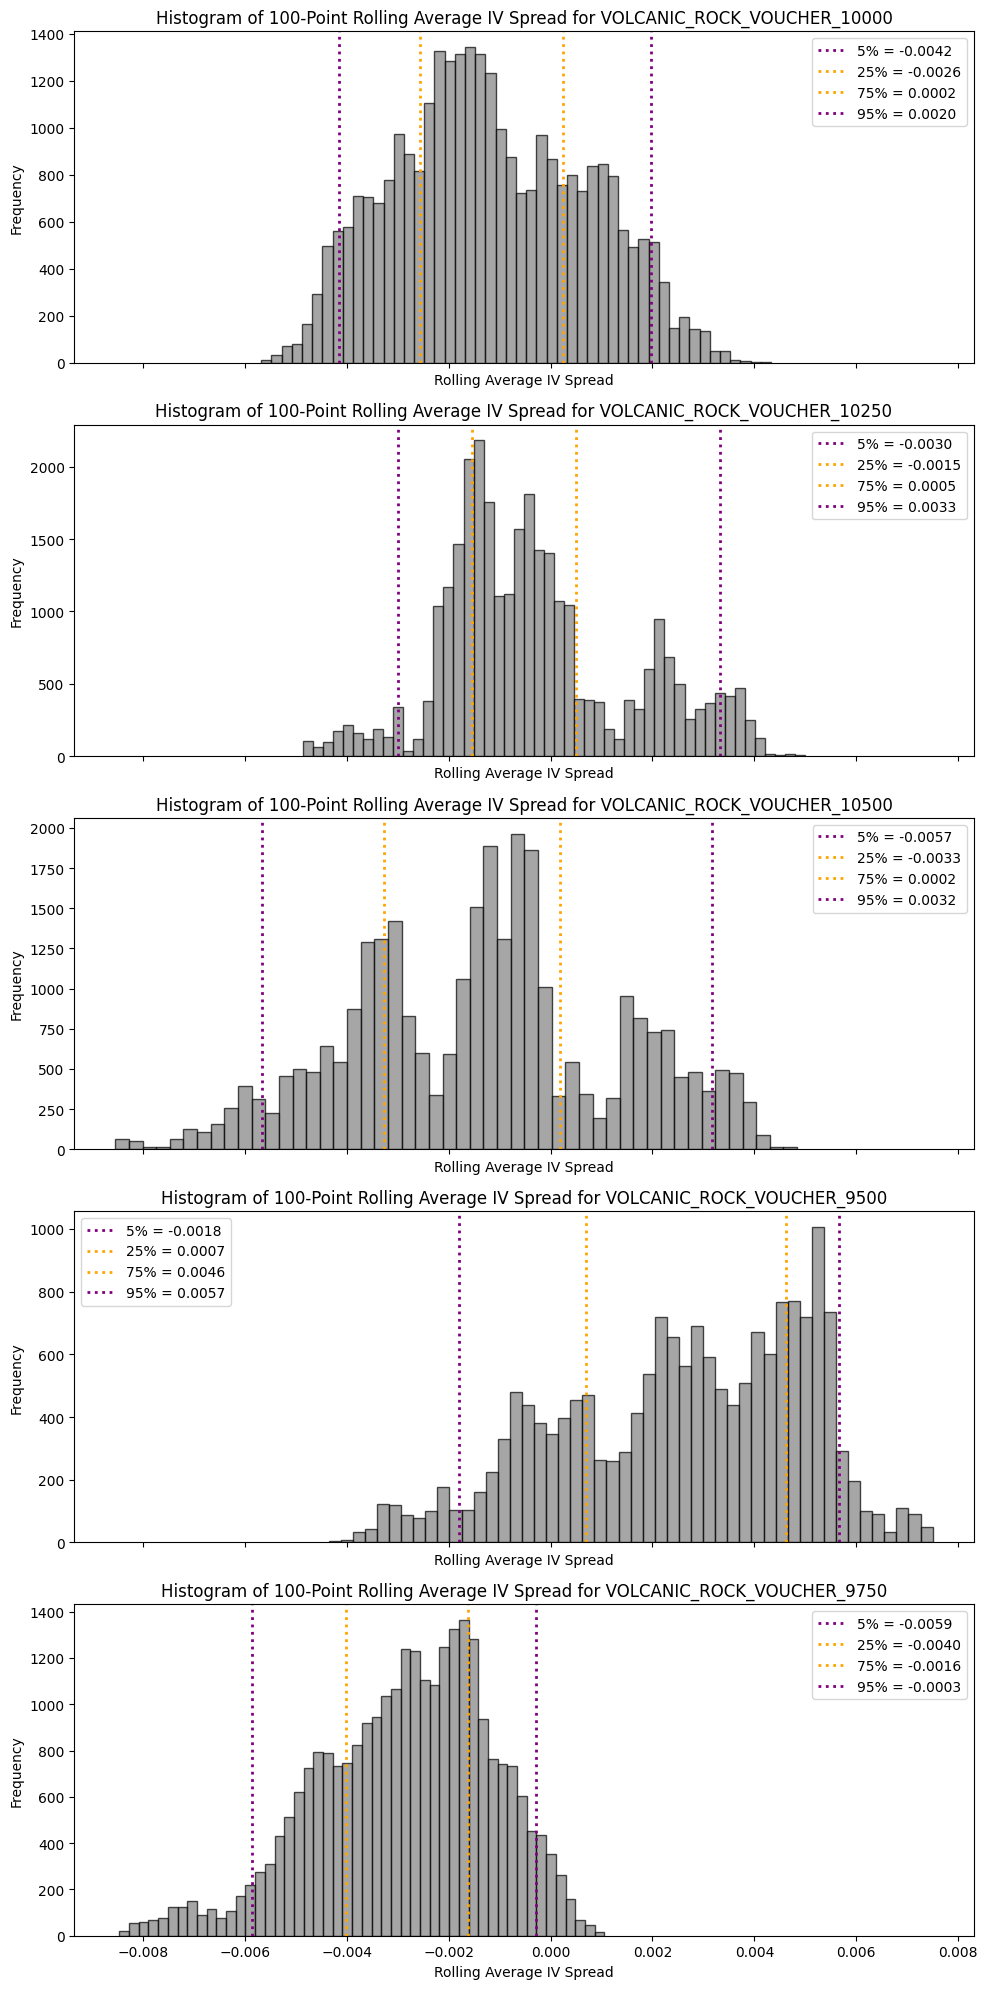

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# Determine the data source.
# ---------------------------
if 'v_t' in df_merged.columns and 'm_t' in df_merged.columns:
    source_df = df_merged.copy()
    print("Using df_merged as data source for rolling average IV spread.")
elif 'df_downsampled' in globals() and 'v_t' in df_downsampled.columns and 'm_t' in df_downsampled.columns:
    source_df = df_downsampled.copy()
    print("Using df_downsampled as data source for rolling average IV spread.")
else:
    raise Exception("No data with 'v_t' and 'm_t' found in df_merged or df_downsampled.")

# ---------------------------
# Filter for voucher data.
# ---------------------------
voucher_mask = source_df['product'].str.startswith("VOLCANIC_ROCK_VOUCHER_")
voucher_data = source_df[voucher_mask].copy()
print("Number of voucher rows:", len(voucher_data))

# ---------------------------
# Define model parameters.
# ---------------------------
a = 0.280227
b = 0.003789
c = 0.125000

# Compute model IV and the IV spread.
voucher_data['v_model'] = a * voucher_data['m_t']**2 + b * voucher_data['m_t'] + c
voucher_data['iv_diff'] = voucher_data['v_t'] - voucher_data['v_model']

# ---------------------------
# Compute composite time for proper ordering (if not present).
# ---------------------------
max_ts = 999000
offset = 1000
if 'composite_time' not in voucher_data.columns:
    # Assumes that 'day' and 'timestamp' columns exist.
    voucher_data['composite_time'] = voucher_data['day'] * (max_ts + offset) + voucher_data['timestamp']

# ---------------------------
# Define the rolling window size.
# ---------------------------
rolling_window = 100

# We will compute a 100-point rolling average for the IV spread for each voucher.
# Create a new DataFrame column 'rolling_iv_diff' per group.
# First, sort each voucher’s data by composite_time.
voucher_data.sort_values(by=['product', 'composite_time'], inplace=True)

# Compute the rolling average of the IV spread (iv_diff) for each voucher.
voucher_data['rolling_iv_diff'] = voucher_data.groupby('product')['iv_diff'] \
    .rolling(window=rolling_window, min_periods=rolling_window).mean() \
    .reset_index(level=0, drop=True)

# ---------------------------
# Compute Percentiles for Each Voucher’s Rolling Average.
# ---------------------------
percentile_results = {}
for product, group in voucher_data.groupby('product'):
    # Drop NaNs (the first rolling_window-1 entries will be NaN).
    valid = group['rolling_iv_diff'].dropna()
    if len(valid) == 0:
        continue
    percentiles = valid.quantile([0.05, 0.25, 0.75, 0.95])
    percentile_results[product] = percentiles
    print(f"\nProduct: {product}")
    print(percentiles)

# ---------------------------
# Plot Histograms for Each Voucher’s 100-Point Rolling Average IV Spread.
# ---------------------------
unique_products = list(percentile_results.keys())
n_products = len(unique_products)
fig, axs = plt.subplots(n_products, 1, figsize=(10, 4 * n_products), sharex=True)
if n_products == 1:
    axs = [axs]

for ax, product in zip(axs, unique_products):
    group = voucher_data[voucher_data['product'] == product]
    valid = group['rolling_iv_diff'].dropna()
    if len(valid) == 0:
        continue
    pct = percentile_results[product]
    
    ax.hist(valid, bins=50, color='gray', alpha=0.7, edgecolor='black')
    ax.axvline(pct.loc[0.05], color='purple', linestyle='dotted', linewidth=2, label=f"5% = {pct.loc[0.05]:.4f}")
    ax.axvline(pct.loc[0.25], color='orange', linestyle='dotted', linewidth=2, label=f"25% = {pct.loc[0.25]:.4f}")
    ax.axvline(pct.loc[0.75], color='orange', linestyle='dotted', linewidth=2, label=f"75% = {pct.loc[0.75]:.4f}")
    ax.axvline(pct.loc[0.95], color='purple', linestyle='dotted', linewidth=2, label=f"95% = {pct.loc[0.95]:.4f}")
    
    ax.set_title(f"Histogram of 100-Point Rolling Average IV Spread for {product}")
    ax.set_xlabel("Rolling Average IV Spread")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()


Using df_downsampled for plotting actual IV values.
Processing voucher strike 9500: 17422 rows found.
Processing voucher strike 9750: 27730 rows found.
Processing voucher strike 10000: 30000 rows found.
Processing voucher strike 10250: 30000 rows found.
Processing voucher strike 10500: 30000 rows found.


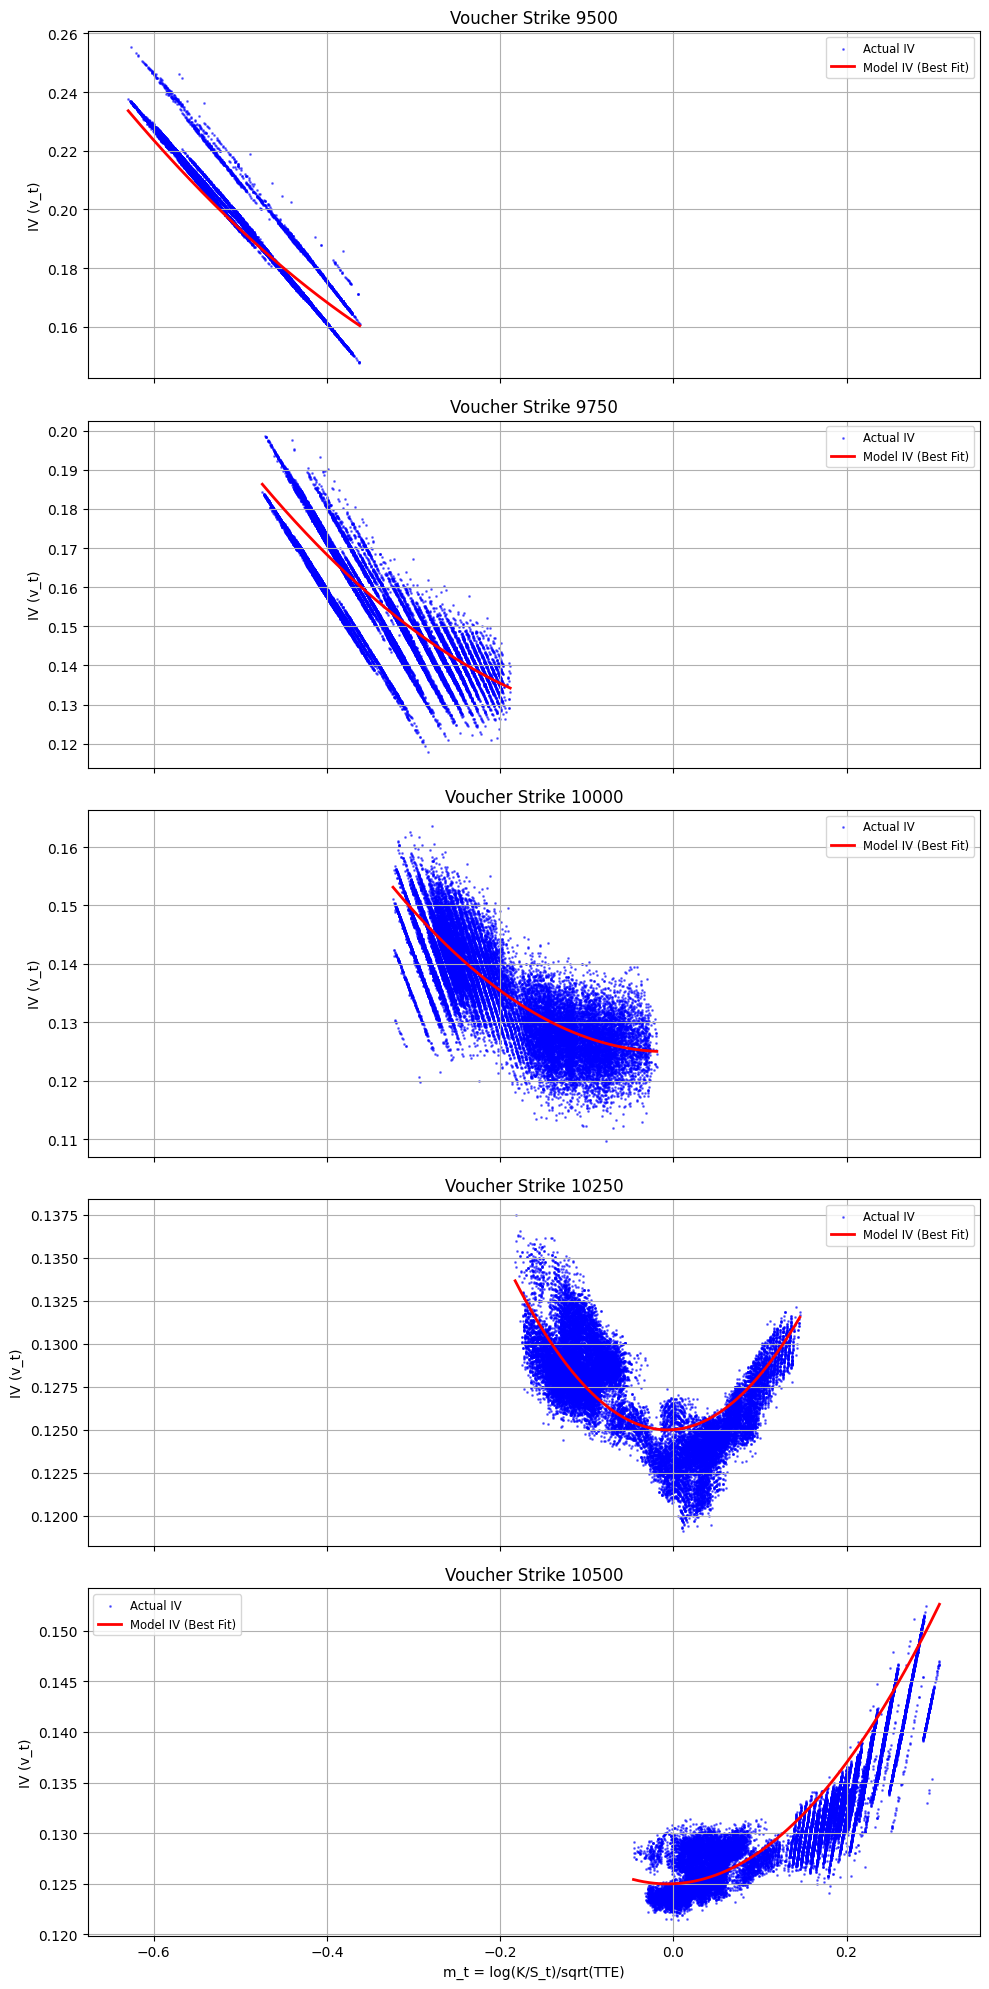

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Given best-fit model coefficients.
a = 0.280227
b = 0.003789
c = 0.125000

# List of voucher strikes to plot.
target_strikes = [9500, 9750, 10000, 10250, 10500]

# Determine the source DataFrame: use df_merged if it contains 'v_t', otherwise fallback to df_downsampled.
if 'v_t' in df_merged.columns:
    source_df = df_merged.copy()
    print("Using df_merged for plotting actual IV values.")
elif 'df_downsampled' in globals() and 'v_t' in df_downsampled.columns:
    source_df = df_downsampled.copy()
    print("Using df_downsampled for plotting actual IV values.")
else:
    raise Exception("No computed v_t found in either df_merged or df_downsampled.")

# Create subplots: one subplot per voucher.
fig, axs = plt.subplots(len(target_strikes), 1, figsize=(10, 20), sharex=True)

# Ensure axs is iterable even if only one subplot.
if len(target_strikes) == 1:
    axs = [axs]

for i, strike in enumerate(target_strikes):
    # Filter the data for the voucher with this strike.
    df_voucher = source_df[source_df['K'] == strike].copy()
    print(f"Processing voucher strike {strike}: {len(df_voucher)} rows found.")
    
    if df_voucher.empty:
        print(f"No data found for voucher strike {strike}, skipping.")
        continue

    # Sort data by m_t for a smooth curve.
    df_voucher.sort_values(by='m_t', inplace=True)
    
    # Calculate the model IV based on the fixed parabolic model.
    df_voucher['v_model'] = a * df_voucher['m_t']**2 + b * df_voucher['m_t'] + c
    
    # Create a smooth model curve.
    x_min = df_voucher['m_t'].min()
    x_max = df_voucher['m_t'].max()
    x_model = np.linspace(x_min, x_max, 300)
    y_model = a * x_model**2 + b * x_model + c
    
    ax = axs[i]
    ax.scatter(df_voucher['m_t'], df_voucher['v_t'], color='blue', s=1, alpha=0.5, label="Actual IV")
    ax.plot(x_model, y_model, color='red', linewidth=2, label="Model IV (Best Fit)")
    ax.set_title(f"Voucher Strike {strike}")
    ax.set_ylabel("IV (v_t)")
    ax.legend(fontsize='small')
    ax.grid(True)

plt.xlabel("m_t = log(K/S_t)/sqrt(TTE)")
plt.tight_layout()
plt.show()


Using df_downsampled as data source for the piecewise fit.
Breakpoints for m_t: [-8.00000000e-01 -6.00000000e-01 -4.00000000e-01 -2.00000000e-01
 -2.22044605e-16  2.00000000e-01  4.00000000e-01]


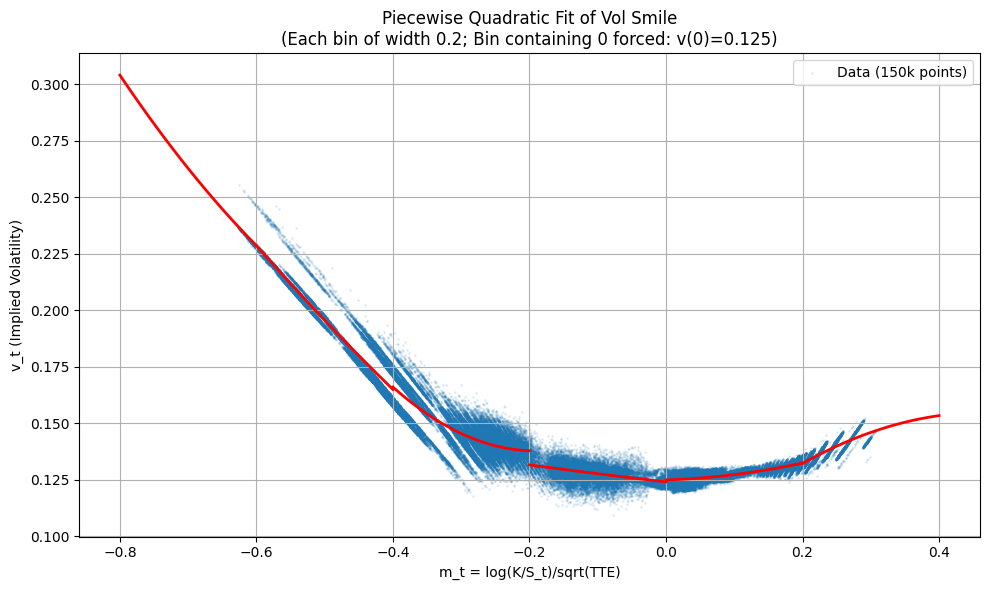

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Determine which DataFrame to use for the (m_t, v_t) data.
# We prefer df_merged if available.
if 'v_t' in df_merged.columns:
    source_df = df_merged.copy()
    print("Using df_merged as data source for the piecewise fit.")
elif 'df_downsampled' in globals() and 'v_t' in df_downsampled.columns:
    source_df = df_downsampled.copy()
    print("Using df_downsampled as data source for the piecewise fit.")
else:
    raise Exception("No computed v_t found in available data.")

# Extract m_t and v_t values.
x = source_df['m_t'].values
y = source_df['v_t'].values

# Scatter-plot the full data.
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=1, alpha=0.1, label="Data (150k points)")

# Define the bin width for m_t.
bin_width = 0.2

# Set breakpoints that cover the entire range.
m_min = np.min(x)
m_max = np.max(x)
# Round down/up to the nearest multiple of bin_width.
start = np.floor(m_min / bin_width) * bin_width
end   = np.ceil(m_max / bin_width) * bin_width
breakpoints = np.arange(start, end+bin_width, bin_width)
print("Breakpoints for m_t:", breakpoints)

# Loop over each bin and perform a quadratic fit.
for i in range(len(breakpoints) - 1):
    bin_low = breakpoints[i]
    bin_high = breakpoints[i+1]
    # Extract data points in this bin (we use left inclusive, right exclusive)
    mask = (x >= bin_low) & (x < bin_high)
    x_bin = x[mask]
    y_bin = y[mask]
    
    # Skip bins with too few points (say fewer than 10).
    if len(x_bin) < 10:
        continue

    # Determine if this bin contains m_t = 0.
    if bin_low <= 0 < bin_high:
        # Constrained quadratic fit: force v(0)=0.125.
        # The model: v_t = a*m_t^2 + b*m_t + 0.125.
        # Adjust y: y_adj = v_t - 0.125, and then y_adj = a*m_t^2 + b*m_t.
        y_adj = y_bin - 0.125
        A = np.column_stack((x_bin**2, x_bin))
        coeffs, _, _, _ = np.linalg.lstsq(A, y_adj, rcond=None)
        a_bin, b_bin = coeffs
        c_bin = 0.125  # forced constraint.
    else:
        # Unconstrained quadratic fit on (x_bin, y_bin)
        coeffs = np.polyfit(x_bin, y_bin, 2)  # returns [a, b, c]
        a_bin, b_bin, c_bin = coeffs

    # Generate a smooth curve for the current bin.
    x_dense = np.linspace(bin_low, bin_high, 100)
    y_dense = a_bin * x_dense**2 + b_bin * x_dense + c_bin
    # Plot this segment (in red).
    plt.plot(x_dense, y_dense, color='red', linewidth=2)

plt.xlabel("m_t = log(K/S_t)/sqrt(TTE)")
plt.ylabel("v_t (Implied Volatility)")
plt.title("Piecewise Quadratic Fit of Vol Smile\n(Each bin of width 0.2; Bin containing 0 forced: v(0)=0.125)")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


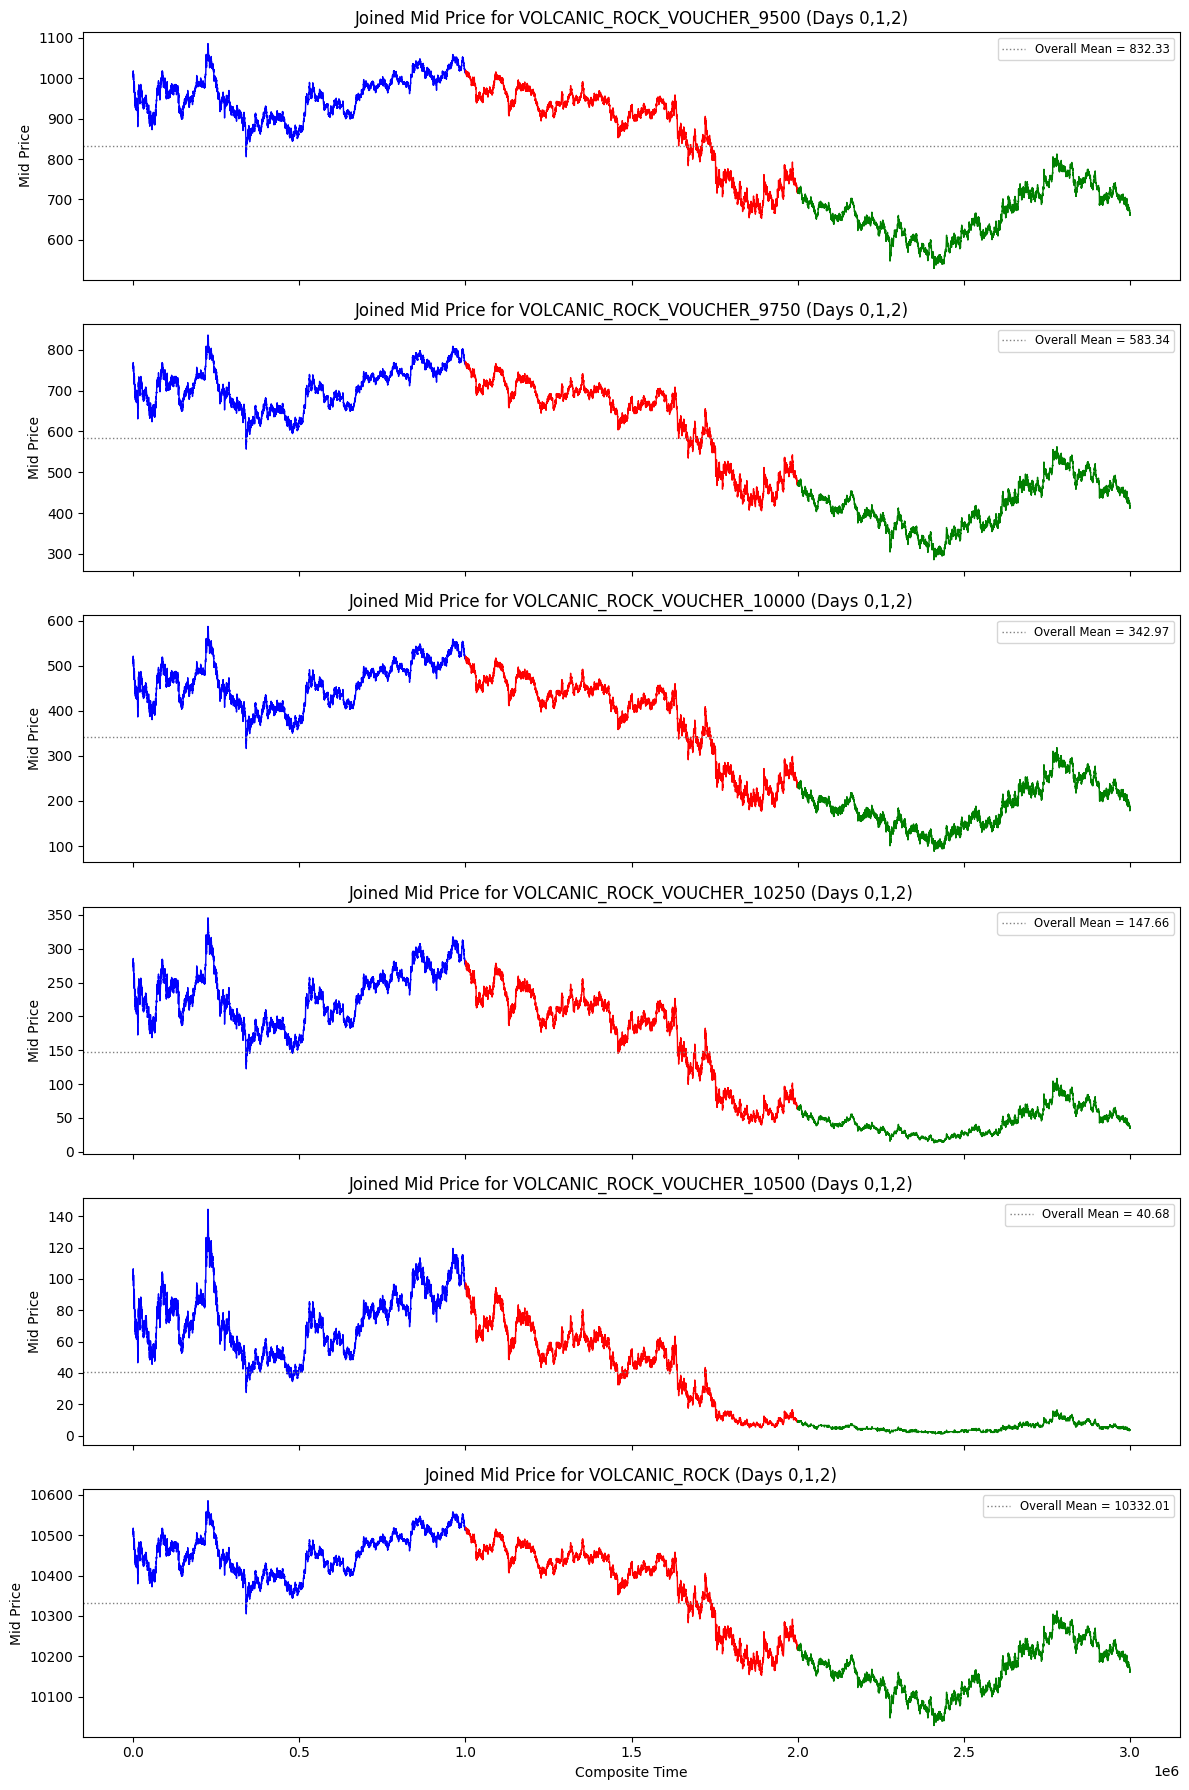

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load day data from CSV files ---
data0 = pd.read_csv('Data/3/prices_round_3_day_0.csv', sep=';', header=0)
data1 = pd.read_csv('Data/3/prices_round_3_day_1.csv', sep=';', header=0)
data2 = pd.read_csv('Data/3/prices_round_3_day_2.csv', sep=';', header=0)

# --- Assign day labels ---
data0['day'] = 0
data1['day'] = 1
data2['day'] = 2

# --- Concatenate data ---
all_data = pd.concat([data0, data1, data2], ignore_index=True)

# --- Compute composite_time: shift each day's timestamps so that they are end-to-end ---
# Here we assume that each day's 'timestamp' starts at 0 and ends below max_ts.
# You can adjust max_ts and offset as needed.
max_ts = 999000
offset = 1000
all_data['composite_time'] = all_data['day'] * (max_ts + offset) + all_data['timestamp']

# --- Compute mid_price if not available ---
if 'mid_price' not in all_data.columns and ('best_bid' in all_data.columns and 'best_ask' in all_data.columns):
    all_data['mid_price'] = (all_data['best_bid'] + all_data['best_ask']) / 2

# --- Define the list of products to plot: 5 vouchers and the underlying ---
products = [
    "VOLCANIC_ROCK_VOUCHER_9500",
    "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000",
    "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500",
    "VOLCANIC_ROCK"
]

# --- Define colors to use for each day ---
day_colors = {0: 'blue', 1: 'red', 2: 'green'}

# --- Create subplots (one per product) ---
fig, axs = plt.subplots(len(products), 1, figsize=(12, 3 * len(products)), sharex=True)

for ax, prod in zip(axs, products):
    # Filter the data for this product.
    prod_data = all_data[all_data['product'] == prod].copy()
    if prod_data.empty:
        ax.set_title(f"{prod} - no data")
        continue
    # Sort by composite_time so the points join sequentially.
    prod_data.sort_values(by='composite_time', inplace=True)
    
    # Plot each day separately so the segments are color-coded, but since composite_time
    # is continuous, the segments will be joined end-to-end.
    for day, group in prod_data.groupby('day'):
        group = group.sort_values(by='composite_time')
        ax.plot(group['composite_time'], group['mid_price'],
                color=day_colors.get(day, 'black'),
                linewidth=1, linestyle='-')  # thin line, no markers
    
    # Compute and plot a single mean line across all 3 days for this product.
    overall_mean = prod_data['mid_price'].mean()
    ax.axhline(y=overall_mean, color='gray', linestyle=':', linewidth=1,
               label=f"Overall Mean = {overall_mean:.2f}")
    
    ax.set_title(f"Joined Mid Price for {prod} (Days 0,1,2)")
    ax.set_ylabel("Mid Price")
    ax.legend(fontsize='small')

axs[-1].set_xlabel("Composite Time")
plt.tight_layout()
plt.show()
